## Hook callbacks

这提供了一个独立的类和一个回调，用于注册和自动注销PyTorch钩子，以及一些预定义的钩子。 挂钩可以连接到任何nn.Module，用于前向和后向传播。

我们首先看一下预定义的钩子ActivationStats，然后我们将看到如何创建自己的钩子。

### class ActivationStats

`ActivationStats(learn:Learner, modules:Sequence[Module]=None, do_remove:bool=True) :: HookCallback`

记录激活的平均值和标准的回调。

ActivationStats将self.stats中的图层激活保存为传递给它的所有模块。 默认情况下，它将保存所有模块的激活。 例如：

In [1]:
from fastai.vision import *
from fastai.basics import *
from fastai.callbacks import *

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)
#learn = cnn_learner(data, models.resnet18, callback_fns=ActivationStats)
learn = Learner(data, simple_cnn((3,16,16,2)), callback_fns=ActivationStats)
learn.fit(1)

epoch,train_loss,valid_loss,time
0,0.126865,0.104973,02:27


保存的统计信息是FloatTensor的形状（2，num_modules，num_batches）。 第一个轴是（mean，stdev）。

In [3]:
len(learn.data.train_dl),len(learn.activation_stats.modules)

(193, 3)

In [4]:
learn.activation_stats.stats.shape

torch.Size([2, 3, 193])

因此，这显示了每个批次（axis2）的第2个最后一层（axis1 ==  -  2）的标准偏差（axis0 == 1）：

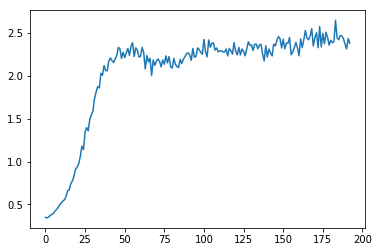

In [5]:
plt.plot(learn.activation_stats.stats[1][-2].numpy());

### Internal implementation
<b>hook</b>

`hook(m:Module, i:Tensors, o:Tensors) → Tuple[Rank0Tensor, Rank0Tensor]`

取o的平均值和标准值。

### Callback methods
你不要自己调用 - 他们会被fastai的Callback系统自动调用，以启用该类的功能。

<b>on_train_begin</b>

`on_train_begin(**kwargs)`

初始化统计数据。

<b>on_batch_end</b>

`on_batch_end(train, **kwargs)`

获取存储的结果并将其放入self.stats中

<b>on_train_end</b>

`on_train_end(**kwargs)`

抛光最终结果。

### class Hook

`Hook(m:Module, hook_func:HookFunc, is_forward:bool=True, detach:bool=True)`

使用hook_func在m上创建一个钩子。

注册并手动取消注册PyTorch挂钩。 当运行模块m的前进/后退（取决于is_forward）时，将自动调用hook_func，并将该函数的结果放在self.stored中。

<b>remove</b>

`remove()`

从模型中删除钩子。

如果没有调用钩子，则取消注册。

### class Hooks

`Hooks(ms:ModuleList, hook_func:HookFunc, is_forward:bool=True, detach:bool=True)`

使用hook_func在ms中创建几个模块挂钩。

作为一个集合（即len（钩子）和钩子[i]）和一组钩子的迭代器（即挂钩），每个模块一个以毫秒为单位，能够将所有作为一个组删除。 使用stored来获取所有钩子结果。 hook_func和is_forward行为与Hook相同。 有关简单示例，请参阅HookCallback的源代码。

<b>remove</b>

`remove()`

从模型中删除钩子。

如果以前没有调用过，请取消注册此类创建的所有挂钩。

## Convenience functions for hooks
<b>hook_output</b>

`hook_output(module:Module, detach:bool=True, grad:bool=False) → Hook`

返回一个Hook，用于存储self.stored中模块的激活

为模块创建Hook的函数，该模块只存储图层的输出。

<b>hook_outputs</b>

`hook_outputs(modules:ModuleList, detach:bool=True, grad:bool=False) → Hooks`

返回存储自我存储中所有模块激活的挂钩

为所有传递的模块创建Hook的函数，该模块只存储层的输出。 例如，model_sizes的（略微简化的）源代码是：

```python
def model_sizes(m, size):
    x = m(torch.zeros(1, in_channels(m), *size))
    return [o.stored.shape for o in hook_outputs(m)]
```

<b>model_sizes</b>

`model_sizes(m:Module, size:tuple=(64, 64)) → Tuple[Sizes, Tensor, Hooks]`

通过模型m传递虚拟输入以获得各种大小的激活。

<b>model_summary</b>

`model_summary(m:Learner, n:int=70)`

使用n个字符的输出文本宽度打印m的摘要

此方法仅适用于其中包含train_ds的Learner对象。 如果它是作为load_learner的结果创建的，则没有数据可以在模型中运行，因此无法创建此类摘要。

示例摘要如下所示：

```python
======================================================================
Layer (type)         Output Shape         Param #    Trainable 
======================================================================
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
...
```

列定义：

1. <b>Layer (type) </b>是相应nn.Module的名称。

2. <b>Output Shape</b>是相应图层输出的形状（减去批量维度，它始终相同，对模型参数没有影响）。

3. <b>Param＃</b>是权重的数量（以及可选的偏差），并且每个层都会有所不同。
    对于每种层类型，params的数量计算方式不同。 以下是一些最常见的图层类型的计算方法：

        * Conv: kernel_size*kernel_size*ch_in*ch_out
        * Linear: (n_in+bias) * n_out
        * Batchnorm: 2 * n_out
        * Embeddings: n_embed * emb_sz
4. <b>Trainable</b> 表示图层是否可训练。
        * 具有0个参数的层总是不可解决的（例如，ReLU和MaxPool2d）。
        * 其他层可以是可训练的，也可以不是，通常取决于它们是否被冷冻。 见Discriminative layer training。

为了更好地理解此摘要，还有助于执行learn.model并关联两个输出。

例：

让我们向学习者提供一个大小为352x352的3通道图像数据集，并查看模型及其摘要：

```python
data.train_ds[0][0].data.shape
learn = cnn_learner(data, models.resnet34, ...)
print(learn.model)
print(learn.summary())
```
以下是除了与示例行相关的所有内容的输出：

```python
torch.Size([3, 352, 352])

    [...]
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    [...]
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    [...]
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): Linear(in_features=512, out_features=37, bias=True)


======================================================================
Layer (type)         Output Shape         Param #    Trainable 
======================================================================
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
[...]
MaxPool2d            [64, 88, 88]         0          False    
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
[...]
______________________________________________________________________
Linear               [37]                 18,981     True
```

<b>所以让我们计算一些参数：</b>

对于Conv2d图层，将相应图层定义中的前4个数字相乘：

```python
Conv2d(3, 64, kernel_size=(7, 7), ...)

3*64*7*7 = 9,408

Conv2d(64, 64, kernel_size=(3, 3), ...)

64*64*3*3 = 36,864
```
对于BatchNorm2d图层，将第一个数字乘以2：

```python
BatchNorm2d(64, ...)
64*2 = 128
```

对于线性，我们将前2乘以并包括偏差，如果它是真的：

```python
Linear(in_features=512, out_features=37, bias=True)

(512+1)*37 = 18,981
```

<b>现在让我们计算一些输出形状：</b>

我们从3x352x352图像开始并通过该层运行它：

`Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)`

我们是怎么得到的: [64, 176, 176]

输出通道的数量是64，这是上面数字中的第一个维度。 然后我们352x352的图像由于步幅2x2（352/2）而被卷入176x176。

之后我们有：

`MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)`

由于步幅2，再次将[64,176,176]减少到[64,88,88]。

等等，完成：

`Linear(in_features=512, out_features=37, bias=True)`

这使得一切都减少到[37]。

<b>num_features_model</b>

`num_features_model(m:Module) → int`

返回模型的输出要素数。

获取模型的每个层的大小（例如，用于打印摘要或用于为DynamicUnet生成交叉连接）可能很有用，但是它们取决于输入的大小。 此函数通过传入最小张量的大小来计算图层大小。

<b>dummy_batch</b>

`dummy_batch(m:Module, size:tuple=(64, 64)) → Tensor`

创建一个虚拟批次以通过m大小。

<b>dummy_eval</b>

`dummy_eval(m:Module, size:tuple=(64, 64))`

在m的评估模式下传递一个dummy_batch，其大小。

### class HookCallback

`HookCallback(learn:Learner, modules:Sequence[Module]=None, do_remove:bool=True) :: LearnerCallback`
        
可用于在模块上注册挂钩的回调。 在self.hook中实现相应的功能。

对于所有模块，使用回调自动注册方法self.hook（必须在继承的类中定义）作为钩子。 此方法必须具有签名：

`def hook(self, m:Model, input:Tensors, output:Tensors)`

如果do_remove，那么钩子会在训练结束时自动注销。 有关从此类继承的简单示例，请参阅ActivationStats。

### Callback methods

你不要自己调用 - 他们会被fastai的Callback系统自动调用，以启用该类的功能。

<b>on_train_begin</b>

`on_train_begin(**kwargs)`

在self.modules上注册Hooks。

<b>on_train_end</b>

`on_train_end(**kwargs)`

取下挂钩。